In [4]:
pip install yfinance

[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
37/37 [==============================] - 25s 135ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 2/50
37/37 [==============================] - 4s 102ms/step - loss: 6.0297e-05 - val_loss: 0.0011
Epoch 3/50
37/37 [==============================] - 3s 80ms/step - loss: 4.6942e-05 - val_loss: 0.0013
Epoch 4/50
37/37 [==============================] - 4s 112ms/step - loss: 4.7403e-05 - val_loss: 0.0012
Epoch 5/50
37/37 [==============================] - 5s 137ms/step - loss: 4.2542e-05 - val_loss: 0.0017
Epoch 6/50
37/37 [==============================] - 6s 167ms/step - loss: 4.2175e-05 - val_loss: 0.0018
Epoch 7/50
37/37 [==============================] - 5s 123ms/step - loss: 3.9984e-05 - val_loss: 0.0017
Epoch 8/50
37/37 [==============================] - 4s 101ms/step - loss: 3.9613e-05 - val_loss: 0.0032
Epoch 9/50
37/37 [==============================] - 4s 97ms/step - loss: 3.9040e-05 - val_loss: 0.0023


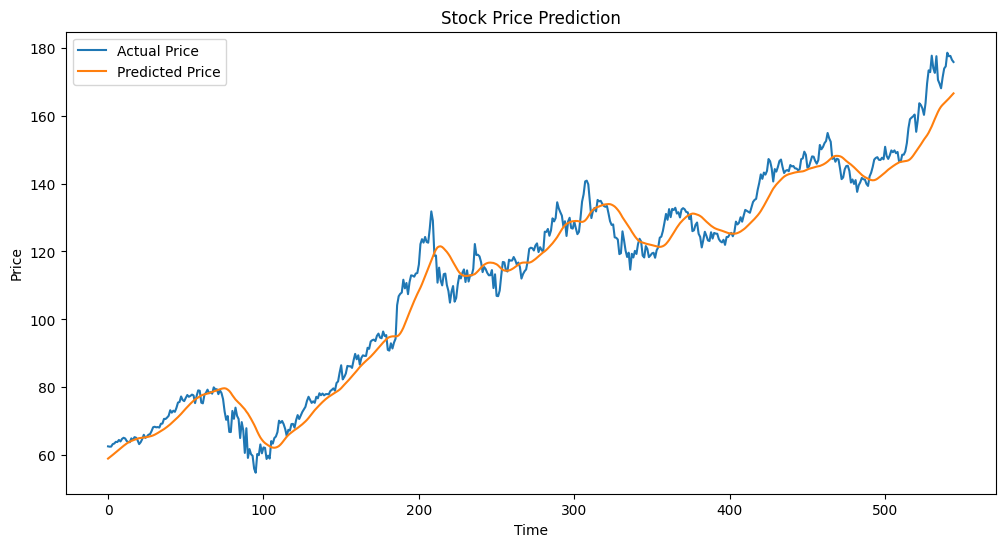

In [5]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Data Collection and Preprocessing
def fetch_stock_data(company, start_date, end_date):
    # Fetch historical stock price data
    df = yf.download(company, start=start_date, end=end_date)
    return df

def preprocess_data(data):
    # Select relevant columns (e.g., Adj Close for closing prices)
    data = data[['Adj Close']]

    # Check for missing values and handle them if necessary
    data = data.dropna()

    return data

def scale_and_split_data(data, sequence_length):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Split the data into training and testing sets
    train_size = int(len(scaled_data) * 0.8)
    train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

    # Create sequences
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    return X_train, y_train, X_test, y_test, scaler

# RNN Model Architecture
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    return model

# Model Training
def train_model(model, X_train, y_train, batch_size, epochs, validation_data, callbacks):
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=callbacks)

    return model, history

# Model Evaluation
def evaluate_model(model, X_test, y_test, scaler):
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions)
    rmse = mean_squared_error(scaler.inverse_transform(y_test), predictions, squared=False)

    return mae, rmse, predictions

# Create Sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Main Code
if __name__ == "__main__":
    # Define parameters
    company = "AAPL"  # Example: Apple Inc.
    start_date = "2010-01-01"
    end_date = "2022-01-01"
    sequence_length = 60
    batch_size = 64
    epochs = 50

    # Step 1: Data Collection and Preprocessing
    df = fetch_stock_data(company, start_date, end_date)
    data = preprocess_data(df)
    X_train, y_train, X_test, y_test, scaler = scale_and_split_data(data, sequence_length)

    # Step 2: RNN Model Architecture
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rnn_model(input_shape)

    # Step 3: Model Training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    validation_data = (X_test, y_test)
    model, history = train_model(model, X_train, y_train, batch_size, epochs, validation_data, callbacks)

    # Step 4: Model Evaluation
    mae, rmse, predictions = evaluate_model(model, X_test, y_test, scaler)
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Step 5: Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test), label="Actual Price")
    plt.plot(predictions, label="Predicted Price")
    plt.legend()
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()